In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("scolianni/mnistasjpg")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\BineshMahato\.cache\kagglehub\datasets\scolianni\mnistasjpg\versions\1


In [25]:
import torch
import torchvision

path = r'C:\Users\BineshMahato\.cache\kagglehub\datasets\scolianni\mnistasjpg'

BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST(path, train=True, download=True,
                                       transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.MNIST(path, train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)
     

In [26]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [27]:
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [28]:
!pip install einops

In [34]:
import torch
import torch.nn.functional as F

from torch import nn
from einops import rearrange
import time

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [35]:
import timm

# Example ViT model initialization
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10)


In [36]:
import torch.optim as optim
N_EPOCHS = 25

start_time = time.time()
model = ViT(
    image_size=28, 
    patch_size=7, 
    num_classes=10, 
    channels=1, 
    dim=64, 
    depth=6, 
    heads=8, 
    mlp_dim=128,
)
optimizer = optim.Adam(model.parameters(), lr=0.003)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/60000 (  0%)]  Loss: 2.3815
[10000/60000 ( 17%)]  Loss: 0.3308
[20000/60000 ( 33%)]  Loss: 0.3383
[30000/60000 ( 50%)]  Loss: 0.1686
[40000/60000 ( 67%)]  Loss: 0.2303
[50000/60000 ( 83%)]  Loss: 0.1175

Average test loss: 0.1679  Accuracy: 9492/10000 (94.92%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.1514
[10000/60000 ( 17%)]  Loss: 0.0884
[20000/60000 ( 33%)]  Loss: 0.1410
[30000/60000 ( 50%)]  Loss: 0.0879
[40000/60000 ( 67%)]  Loss: 0.0521
[50000/60000 ( 83%)]  Loss: 0.0657

Average test loss: 0.0989  Accuracy: 9696/10000 (96.96%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.0685
[10000/60000 ( 17%)]  Loss: 0.0592
[20000/60000 ( 33%)]  Loss: 0.0617
[30000/60000 ( 50%)]  Loss: 0.1318
[40000/60000 ( 67%)]  Loss: 0.1410
[50000/60000 ( 83%)]  Loss: 0.1165

Average test loss: 0.0872  Accuracy: 9738/10000 (97.38%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.0533
[10000/60000 ( 17%)]  Loss: 0.1737
[20000/60000 ( 33%)]  Loss: 0.1331
[30000/60000 ( 50%)]  Loss: 0.2481
[40000/60000 ( 67

In [37]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

In [38]:
torch.save(model.state_dict(), 'model-vit-mnist.pth')

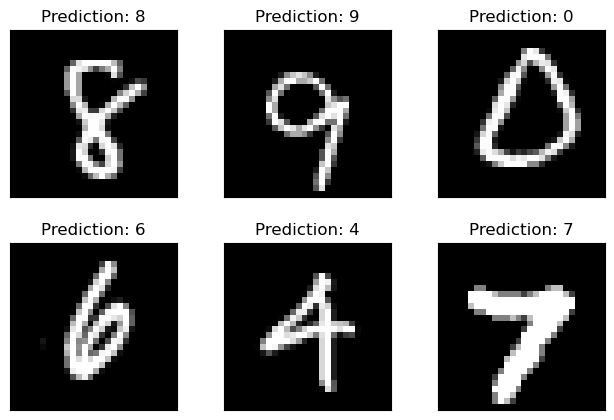

In [39]:
import matplotlib.pyplot as plt

with torch.no_grad():
  output = model(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
     